In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import tensorflow.contrib.slim as slim
import vgg_combo as vgg

import math
import argparse
import pandas as pd

import data_input_jpg as dataset

In [2]:
import csv

districts = dict()
subdistricts = dict()
unique_subdistricts = set()

with open("India_pov_pop_w_district.csv", "r") as original_file:
    villagereader = csv.reader(original_file)
    count = 0
    for row in villagereader:
        count += 1
        if count == 1:
            continue
        districts[row[2]] = row[-2]
        subdistricts[row[2]] = row[-1]
        unique_subdistricts.add(row[-1])

print(len(districts))
print(len(subdistricts))
print(len(unique_subdistricts))

567976
567976
5740


In [3]:
MODELS = {
# new model
"shallowmeancombine_12k_l8s1": {
    "csv": "/home/timhu/dfd-pop/data/annos_csv/state24_jpgpaths_density_nolaps_12k_Mar6.csv",
    "checkpoint": "/home/timhu/dfd-pop/logs/regression_l8s1combo_state24_lr-6_drop08_vgg_Mar7/model.ckpt-5459",
    "model": "vgg",
    "data": "l8s1",
    "channels": 6,
    "pretrained": "vgg_combo",
    "nl": False,
}}

JPG_DIR = '/home/timhu/all_jpg/'

current = MODELS["shallowmeancombine_12k_l8s1"]

CKPT = current["checkpoint"]
ANNOS_CSV = current["csv"]
MODEL = current["model"]
DATA = current["data"]
IMAGE_CHANNEL = current["channels"]
HAS_NL = current["nl"]

IMAGE_HEIGHT = 224 
IMAGE_WIDTH = 224
FLAGS = argparse.Namespace(dropout_keep= 0.8,
                           max_epoch = 30, # maximum number of epoch
                           batch_size= 1, # for eval, go through one by one
                           output_size = 1) # embedding size or class number 

In [4]:
# create input path and labels np.array from csv annotations
df_annos = pd.read_csv(ANNOS_CSV, index_col=0)
#df_annos = df_annos.sample(frac=1).reset_index(drop=True) # shuffle the whole datasets
if DATA == 'l8':
    path_col = ['l8_vis_jpg']
elif DATA == 's1':
    path_col = ['s1_vis_jpg']
elif DATA == 'l8s1':
    path_col = ['l8_vis_jpg', 's1_vis_jpg']

input_files_val = JPG_DIR + df_annos.loc[df_annos.partition == 'val', path_col].values
input_labels_val = df_annos.loc[df_annos.partition == 'val', 'pop_density_log2'].values

input_id_val = df_annos.loc[df_annos.partition == 'val', 'village_id'].values

print('input_files_val shape:', input_files_val.shape)

input_files_val shape: (2497, 2)


In [5]:
sess = tf.Session('', tf.Graph())
with sess.graph.as_default():
    with tf.device('/cpu:0'):
        val_images_batch, val_labels_batch, val_ids_batch = \
            dataset.input_batches(FLAGS.batch_size, FLAGS.output_size, input_files_val, input_labels_val, input_id_val,
                              IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL, regression=True, augmentation=False, 
                                normalization=True, repeat=False)
        val_images_vis_batch, val_labels_vis_batch, val_ids_batch = \
            dataset.input_batches(FLAGS.batch_size, FLAGS.output_size, input_files_val, input_labels_val, input_id_val,
                              IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL, regression=True, augmentation=False, 
                                normalization=False, repeat=False)

    images_l8_placeholder = tf.placeholder(tf.float32, shape=[None, IMAGE_HEIGHT, IMAGE_WIDTH, 3]) 
    images_s1_placeholder = tf.placeholder(tf.float32, shape=[None, IMAGE_HEIGHT, IMAGE_WIDTH, 3])
    labels_placeholder = tf.placeholder(tf.float32, shape=[None,])
    print('finish data input')
    
    # CNN forward reference
    if MODEL == 'vgg':
        outputs, _ = vgg.vgg_16(images_l8_placeholder, images_s1_placeholder, num_classes=FLAGS.output_size, 
                                   dropout_keep_prob=FLAGS.dropout_keep, is_training=False)
        outputs = tf.squeeze(outputs) # change shape from (B,1) to (B,), same as label input
        body_prefix = 'vgg_16'
    
    print('finish forward pass')
    # loss
    labels_real = tf.pow(2.0, labels_placeholder) 
    outputs_real = tf.pow(2.0, outputs)
    loss_real_mae = tf.losses.absolute_difference(labels_real, outputs_real)
    
    sess.run(tf.global_variables_initializer())

    restorer = tf.train.Saver(tf.global_variables())
    restorer.restore(sess, CKPT)
    print('Loading model weights success: ', CKPT)
    
    print("Initialize accuracy metric. Running batches now..")
    count = 0
    real_residuals = []
    all_val_imgs = []
    real_vals = []
    pred_vals = []
    real_log2_vals = []
    pred_log2_vals = []
    
    true_log2_vals_by_district = dict()
    pred_log2_vals_by_district = dict()
    
    true_log2_vals_by_subdistrict = dict()
    pred_log2_vals_by_subdistrict = dict()
    
    no_district_found = []
    no_subdistrict_found = []
    
    while True:
        try:
            curr_images_batch, curr_labels_batch, curr_images_vis_batch, curr_ids_batch = sess.run([val_images_batch, val_labels_batch, val_images_vis_batch, val_ids_batch])
            feed_dict = {images_l8_placeholder: curr_images_batch[:,:,:,:3], images_s1_placeholder: curr_images_batch[:,:,:,3:], labels_placeholder: curr_labels_batch}
            # sess.run(accuracy_metric_update, feed_dict=feed_dict)
            loss_real_mae_val, real_val, pred_val, real_log2_val, pred_log2_val = sess.run([loss_real_mae, labels_real, outputs_real, labels_placeholder, outputs], feed_dict=feed_dict)
            real_residuals.append(loss_real_mae_val)
            real_vals.append(real_val[0])
            pred_vals.append(pred_val)
            real_log2_vals.append(real_log2_val[0])
            pred_log2_vals.append(pred_log2_val)
            all_val_imgs.append(curr_images_vis_batch[0])
            
            vid = curr_ids_batch[0]
            if str(vid) in districts:
                district = districts[str(vid)]
                if district not in true_log2_vals_by_district:
                    true_log2_vals_by_district[district] = 0.0
                if district not in pred_log2_vals_by_district:
                    pred_log2_vals_by_district[district] = 0.0

                true_log2_vals_by_district[district] += real_log2_val[0]
                pred_log2_vals_by_district[district] += pred_log2_val
            else:
                no_district_found.append(str(vid))
                
            if str(vid) in subdistricts:
                subdistrict = subdistricts[str(vid)]
                if subdistrict not in true_log2_vals_by_subdistrict:
                    true_log2_vals_by_subdistrict[subdistrict] = 0.0
                if subdistrict not in pred_log2_vals_by_subdistrict:
                    pred_log2_vals_by_subdistrict[subdistrict] = 0.0

                true_log2_vals_by_subdistrict[subdistrict] += real_log2_val[0]
                pred_log2_vals_by_subdistrict[subdistrict] += pred_log2_val
            else:
                no_subdistrict_found.append(str(vid))
                
            count += 1
            if count % 100 == 0:
                print("Finished batch", count)
            #if count == 5:
            #    break
        except tf.errors.OutOfRangeError:
            break

    print("Completed batches.")
    print(len(no_district_found))
    print(len(no_subdistrict_found))

finish data input
finish forward pass
INFO:tensorflow:Restoring parameters from /home/timhu/dfd-pop/logs/regression_l8s1combo_state24_lr-6_drop08_vgg_Mar7/model.ckpt-5459
Loading model weights success:  /home/timhu/dfd-pop/logs/regression_l8s1combo_state24_lr-6_drop08_vgg_Mar7/model.ckpt-5459
Initialize accuracy metric. Running batches now..
Finished batch 100
Finished batch 200
Finished batch 300
Finished batch 400
Finished batch 500
Finished batch 600
Finished batch 700
Finished batch 800
Finished batch 900
Finished batch 1000
Finished batch 1100
Finished batch 1200
Finished batch 1300
Finished batch 1400
Finished batch 1500
Finished batch 1600
Finished batch 1700
Finished batch 1800
Finished batch 1900
Finished batch 2000
Finished batch 2100
Finished batch 2200
Finished batch 2300
Finished batch 2400
Completed batches.
264
264


3
3


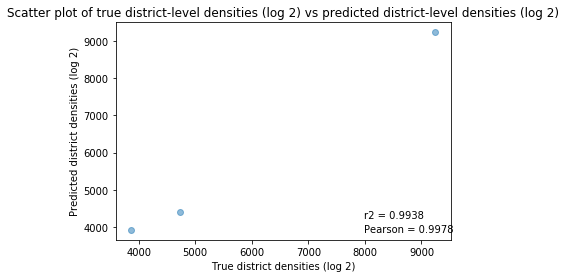

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from scipy.stats import pearsonr

true_district_vals = []
pred_district_vals = []
for district, val in true_log2_vals_by_district.items():
    true_district_vals.append(val)
    pred_district_vals.append(pred_log2_vals_by_district[district])

print(len(true_district_vals))
print(len(pred_district_vals))
    
plt.title("Scatter plot of true district-level densities (log 2) vs predicted district-level densities (log 2)")
plt.ylabel("Predicted district densities (log 2)")
plt.xlabel("True district densities (log 2)")
r2 = r2_score(true_district_vals, pred_district_vals)
p = pearsonr(true_district_vals, pred_district_vals)[0]
plt.figtext(0.7, 0.2, "r2 = %.4f" % r2)
plt.figtext(0.7, 0.15, "Pearson = %.4f" % p)
plt.scatter(true_district_vals, pred_district_vals, alpha=0.5)
plt.show()

20
20
rmse: 59.2221206073
mae: 39.8874739408


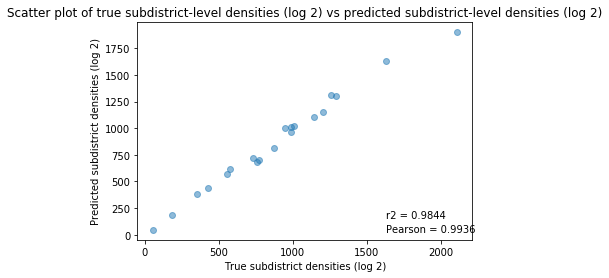

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, mean_absolute_error
from scipy.stats import pearsonr

true_subdistrict_vals = []
pred_subdistrict_vals = []
for subdistrict, val in true_log2_vals_by_subdistrict.items():
    true_subdistrict_vals.append(val)
    pred_subdistrict_vals.append(pred_log2_vals_by_subdistrict[subdistrict])

print(len(true_subdistrict_vals))
print(len(pred_subdistrict_vals))

mse = mean_squared_error(true_subdistrict_vals, pred_subdistrict_vals)
print("rmse:", np.sqrt(mse))

mse = mean_absolute_error(true_subdistrict_vals, pred_subdistrict_vals)
print("mae:", mse)

plt.title("Scatter plot of true subdistrict-level densities (log 2) vs predicted subdistrict-level densities (log 2)")
plt.ylabel("Predicted subdistrict densities (log 2)")
plt.xlabel("True subdistrict densities (log 2)")
r2 = r2_score(true_subdistrict_vals, pred_subdistrict_vals)
p = pearsonr(true_subdistrict_vals, pred_subdistrict_vals)[0]
plt.figtext(0.7, 0.2, "r2 = %.4f" % r2)
plt.figtext(0.7, 0.15, "Pearson = %.4f" % p)
plt.scatter(true_subdistrict_vals, pred_subdistrict_vals, alpha=0.5)
plt.show()

real: 4.85027
pred: 5.97665


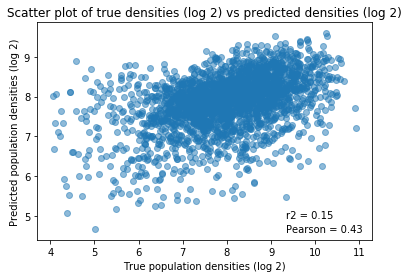

rmse: 1.05712
mae: 0.809881


In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from scipy.stats import pearsonr

print("real:", real_log2_vals[0])
print("pred:", pred_log2_vals[0])
plt.title("Scatter plot of true densities (log 2) vs predicted densities (log 2)")
plt.ylabel("Predicted population densities (log 2)")
plt.xlabel("True population densities (log 2)")
r2 = r2_score(real_log2_vals, pred_log2_vals)
p = pearsonr(real_log2_vals, pred_log2_vals)[0]
plt.figtext(0.7, 0.2, "r2 = %.2f" % r2)
plt.figtext(0.7, 0.15, "Pearson = %.2f" % p)
plt.scatter(real_log2_vals, pred_log2_vals, alpha=0.5)
plt.show()

mse = mean_squared_error(real_log2_vals, pred_log2_vals)
print("rmse:", np.sqrt(mse))

mse = mean_absolute_error(real_log2_vals, pred_log2_vals)
print("mae:", mse)

[4.8502703, 5.3727822, 4.7844872, 6.0358205, 6.1769185]
[5.9766493, 5.5060592, 6.435739, 5.406127, 5.6848249]
max indices:  [ 716 1885 1869]
min indices:  [1812  213 1602]


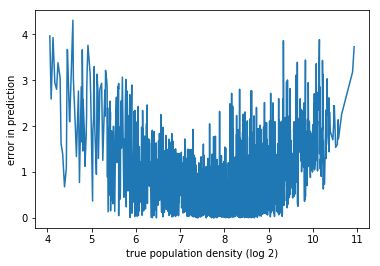

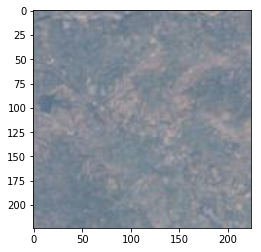

error: 4.31002
real: 4.57693


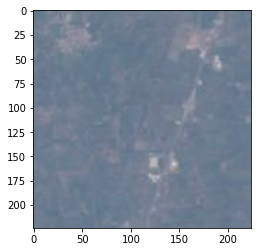

error: 3.96979
real: 4.05529


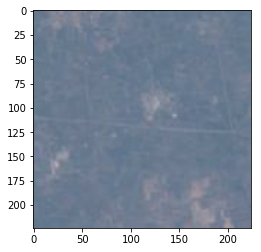

error: 3.93125
real: 4.12778


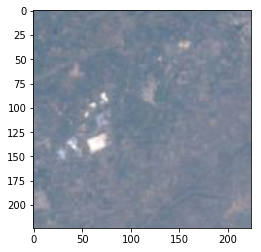

error: 0.00110817
real: 8.35611


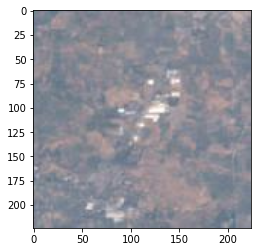

error: 0.00105
real: 8.0976


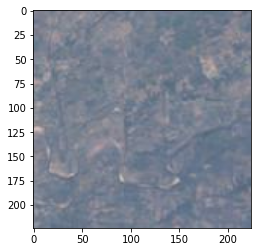

error: 0.000798225
real: 7.75816


In [9]:
# get 5 worst predicted images
import numpy as np
print(real_log2_vals[:5])
print(pred_log2_vals[:5])

real_log2_vals_np = np.array(real_log2_vals)
pred_log2_vals_np = np.array(pred_log2_vals)
diff = np.absolute(real_log2_vals_np - pred_log2_vals_np)

sorted_indices = diff.argsort()[::-1]
max_indices = sorted_indices[:3]
min_indices = sorted_indices[-3:]
print("max indices: ", max_indices)
print("min indices: ", min_indices)

sorted_real_vals_indices = real_log2_vals_np.argsort()
sorted_real_vals = []
errors_at_real_vals = []
for real_idx in sorted_real_vals_indices:
    error_at_real_val = diff[real_idx]
    
    errors_at_real_vals.append(error_at_real_val)
    sorted_real_vals.append(real_log2_vals_np[real_idx])
    
plt.plot(sorted_real_vals, errors_at_real_vals)
plt.xlabel("true population density (log 2)")
plt.ylabel("error in prediction")
plt.show()

for idx in max_indices:
    img = all_val_imgs[idx][:, :, :3]
    err = diff[idx]
    plt.imshow(img)
    plt.show()
    print("error:", err)
    print("real:", real_log2_vals_np[idx])
    
for idx in min_indices:
    img = all_val_imgs[idx][:, :, :3]
    err = diff[idx]
    plt.imshow(img)
    plt.show()
    print("error:", err)
    print("real:", real_log2_vals_np[idx])
